ChEn-3170: Computational Methods in Chemical Engineering Spring 2021 UMass Lowell; Prof. V. F. de Almeida **25Mar21**

# 07. Computational Stoichiometry
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents<a id="toc">
* [Introduction](#intro)
* [Stoichiometric matrix](#stoicmtrx)
* [Linear independent reactions](#indepen)
* [Full-rank, reaction sub-mechanisms](#subreact)
* [Reaction appearance frequency](#rxnfreq)
* [Principal reaction sub-mechanisms](#principal)
---

## [Introduction](#toc)<a id="intro"></a>
"Stoichiometry is essentially the bookkeeping of the material components of a chemical system." Rutherford Aris in Elementary Chemical Reactor Analysis. Computational stoichiometry is the matrix analysis of the stoichiometric matrix of a chemical reaction mechanism. We will use it for several purposes: 
 + Evaluate sets of independent reactions
 + Obtain basic insight on reaction mechanisms from a linear algebra standpoint
 + Evaluate reaction rates and species production rates

Recall course notes OneNote [ChEn-3170-linalg](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EhFgN0Y2du9InQyFejEW-noBWOlMwmU9A79NcNQN345W2Q?e=R7nlu7).

Also refer to the course notes OneNote [ChEn-3170-stoic](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Evkhba9SC3xOmd2q7jj0k-MBEc_Ci1Quzryh3onHBUM1XQ?e=NQ0zT5) on computational stoichiometry including an introduction to the linear, full-rank, least-squares method.

## [Stoichiometric matrix](#toc)<a id="stoicmtrx"></a>
After reading a reaction mechanism from file, and storing the input data into data types, construct the stoichiometric coefficient matrix, $\Smtrx$.

In [1]:
'''Open file for an ammonia oxidation reaction mechanism'''

import io

# open file in reading mode 'r' (default), text 't' (default)
finput = open('data/ammonia-rxn.txt', 'rt')

!cat 'data/ammonia-rxn.txt' # comment this line on Windows machines (does not work)

#
# Ammonia oxidation mechanism
#
# format
..str:float
4 NH3 + 5 O2        <=> 4 NO  + 6 H2O : K_x = 2.5e+02
4 NH3 + 3 O2        <=> 2 N2  + 6 H2O : K_x = 1.8e+02
4 NH3 + 6 NO        <=> 5 N2  + 6 H2O : K_x = 1.099692e+02
2 NO  + 1 O2        <=> 2 NO2         : K_x = 1e+02
2 NO                <=> 1 N2  + 1 O2  : K_x = 8.485281e-01
1 N2  + 2 O2        <=> 2 NO2         : K_x = 1.178511e+02
4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O : K_x = 1.296e+02


In [2]:
'''Build the reactions list'''

reactions = list()

for line in finput:
    stripped_line = line.strip()
    
    if stripped_line[0] == '#': continue
    if stripped_line[:2] == '..': continue
        
    reactions.append(stripped_line.split(':')[0]) # add data to list
    
finput.close() # close the file
    
for r in reactions: 
    i = reactions.index(r)
    print('r%s'%i,': ',r)

r0 :  4 NH3 + 5 O2        <=> 4 NO  + 6 H2O 
r1 :  4 NH3 + 3 O2        <=> 2 N2  + 6 H2O 
r2 :  4 NH3 + 6 NO        <=> 5 N2  + 6 H2O 
r3 :  2 NO  + 1 O2        <=> 2 NO2         
r4 :  2 NO                <=> 1 N2  + 1 O2  
r5 :  1 N2  + 2 O2        <=> 2 NO2         
r6 :  4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O 


In [3]:
'''Shuffle the order of reactions to avoid any bias'''

import random
random.shuffle(reactions)

for r in reactions: 
    i = reactions.index(r)
    print('r%s'%i,': ',r)

r0 :  2 NO                <=> 1 N2  + 1 O2  
r1 :  2 NO  + 1 O2        <=> 2 NO2         
r2 :  4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O 
r3 :  4 NH3 + 3 O2        <=> 2 N2  + 6 H2O 
r4 :  4 NH3 + 5 O2        <=> 4 NO  + 6 H2O 
r5 :  1 N2  + 2 O2        <=> 2 NO2         
r6 :  4 NH3 + 6 NO        <=> 5 N2  + 6 H2O 


In [4]:
'''Create the species list'''

species_tmp = list()  # temporary list for species

for r in reactions:
    
    left  = r.split('<=>')[0].strip() # reactants side
    right = r.split('<=>')[1].strip() # products side
    
    left_terms  = left.split('+')   # reactant species w/ stoichiometric coeff.
    right_terms = right.split('+')  # product  species w/ stoichiometric coeff.
    
    terms = [ t.strip() for t in left_terms ] + [ t.strip() for t in right_terms ] # list comprehensions
    
    for i in terms:
        
        tmp = i.split(' ') # split stoichiometric coefficient from species name
        
        assert len(tmp)==1 or len(tmp)==2,' terms = %r, i = %r, tmp = %r '%(terms, i, tmp)
        
        if len(tmp) == 2:
            species_tmp.append(tmp[1].strip()) # species name if there is a stoichiometric coeff.
        else:
            species_tmp.append(i.strip()) # species name if there is no stoichiometric coeff.

species_filtered = set(species_tmp) # filter species as a set

species = list(species_filtered)  # convert species set to list 
print('\nspecies =\n',species)
print('# of species =',len(species))


species =
 ['NO', 'O2', 'NO2', 'H2O', 'NH3', 'N2']
# of species = 6


In [5]:
'''Create the stoichiometric matrix'''

import numpy as np

# Initialize the stoichiometric matrix as zero
s_mtrx = np.zeros((len(reactions), len(species)))

for r in reactions:
    
    i_row = reactions.index(r)  # reaction index
    
    left  = r.split('<=>')[0].strip()
    right = r.split('<=>')[1].strip()
    
    left_terms = left.split('+')
    left_terms = [t.strip() for t in left_terms] # in-place clean up
    
    right_terms = right.split('+')
    right_terms = [t.strip() for t in right_terms] # in-place clean up
    
    for t in left_terms: # reactants
        
        tmp = t.split(' ') # split stoichiometric coeff and species name
        
        if len(tmp) == 2: # stoich coeff and species name
            coeff = float(tmp[0].strip())
            species_member = tmp[1].strip()
            j_col = species.index(species_member) # find id of species in the species list
            
            assert s_mtrx[i_row,j_col] == 0.0, \
                   'duplicates not allowed r%r: %r %r r'%\
                   (i_row,r,species_member,s_mtrx[i_row,j_col])
            
            s_mtrx[i_row,j_col] = -1.0 * coeff
            
        else: # only species name
            species_member = tmp[0].strip()
            j_col = species.index(species_member)
            
            assert s_mtrx[i_row,j_col] == 0.0, \
                   'duplicates not allowed r%r: %r %r r'%\
                   (i_row,r,species_member,s_mtrx[i_row,j_col])
            
            s_mtrx[i_row,j_col] = -1.0

    for t in right_terms: # products
        
        tmp = t.split(' ')
        
        if len(tmp) == 2:
            coeff = float(tmp[0].strip())
            species_member = tmp[1].strip()
            j_col = species.index(species_member)
            
            assert s_mtrx[i_row,j_col] == 0.0, \
                   'duplicates not allowed r%r: %r %r r'%\
                   (i_row,r,species_member,s_mtrx[i_row,j_col])
            
            s_mtrx[i_row,j_col] = 1.0 * coeff
        else:
            species_member = tmp[0].strip()
            j_col = species.index(species_member)
            
            assert s_mtrx[i_row,j_col] == 0.0, \
                   'duplicates not allowed r%r: %r %r r'%\
                   (i_row,r,species_member,s_mtrx[i_row,j_col])
            s_mtrx[i_row,j_col] = 1.0

print('m x n =',s_mtrx.shape)
print('s_mtrx =\n',s_mtrx)

m x n = (7, 6)
s_mtrx =
 [[-2.  1.  0.  0.  0.  1.]
 [-2. -1.  2.  0.  0.  0.]
 [-4. -1.  0.  6. -4.  4.]
 [ 0. -3.  0.  6. -4.  2.]
 [ 4. -5.  0.  6. -4.  0.]
 [ 0. -2.  2.  0.  0. -1.]
 [-6.  0.  0.  6. -4.  5.]]


r0 :  2 NO                <=> 1 N2  + 1 O2  
r1 :  2 NO  + 1 O2        <=> 2 NO2         
r2 :  4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O 
r3 :  4 NH3 + 3 O2        <=> 2 N2  + 6 H2O 
r4 :  4 NH3 + 5 O2        <=> 4 NO  + 6 H2O 
r5 :  1 N2  + 2 O2        <=> 2 NO2         
r6 :  4 NH3 + 6 NO        <=> 5 N2  + 6 H2O 
n_reactions = 7

species ['NO', 'O2', 'NO2', 'H2O', 'NH3', 'N2']
s_mtrx =
 [[-2.  1.  0.  0.  0.  1.]
 [-2. -1.  2.  0.  0.  0.]
 [-4. -1.  0.  6. -4.  4.]
 [ 0. -3.  0.  6. -4.  2.]
 [ 4. -5.  0.  6. -4.  0.]
 [ 0. -2.  2.  0.  0. -1.]
 [-6.  0.  0.  6. -4.  5.]]
m x n = (7, 6)
matrix shape = (7, 6)


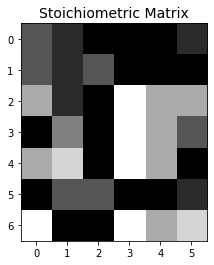

In [6]:
'''Summary'''

from chen_3170.help import print_reactions

print_reactions( reactions )

print('')
print('species',species)
print('s_mtrx =\n',s_mtrx)
print('m x n =',s_mtrx.shape)

from chen_3170.help import plot_matrix

plot_matrix(s_mtrx, title='Stoichiometric Matrix')

## [Linearly independent reactions](#toc)<a id="indepen"></a>
The stoichiometric matrix represents a linear system of equations in three different instances. 
1. First, a mass balance set of equations for the chemical reactions when the molar masses of the species involved are used as a vector. The product of the stoichiometric matrix and this vector must result in the zero vector, *i.e.* $\Smtrx\,\mvec = \zerovec$. 
1. Second, the reaction rates are related to the species production rates in a similar way, *i.e.*, $\Smtrx^\top\,\rvec = \gvec$. In both cases the system of equations lead to a rectangular system in most of the realistic cases. Here we compute the rank of the stoichiometric matrix to discover how many of the reactions are linearly independent.
1. Third, the solution of chemical equilibrium functions involves the stoichiometric matrix in the non-linear algebraic equation solver.

In [7]:
'''How many reactions are independent?'''

# The rank of the stoichiometric matrix is needed

try:    
    from chen_3170.toolkit import lu_factorization   
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'

# using complete pivoting
(l_mtrx, u_mtrx, p_mtrx, q_mtrx, s_rank) = lu_factorization(s_mtrx, 'complete', pivot_tol=1e-5)

print('my rank =', s_rank)
print('numpy rank = ', np.linalg.matrix_rank(s_mtrx, tol=1e-5))
np.set_printoptions(precision=2)
print('u_mtrx =\n',u_mtrx)

my rank = 3
numpy rank =  3
u_mtrx =
 [[ 6. -4.  0. -1. -4.  4.]
 [ 0.  8.  0. -4.  0. -4.]
 [ 0.  0.  2. -2.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


In [ ]:
'''How many reactions are independent?'''

# partial pivoting could fail
#(p_mtrx, l_mtrx, u_mtrx, rank) = lu_factorization( s_mtrx, 'partial', pivot_tol=1e-5 )

#print('my rank =',rank)
#print('u_mtrx =\n',u_mtrx)

In [ ]:
'''How many reactions are independent? Let's break partial pivoting'''

# partial pivoting could fail; try all cases of reaction permutation
#import math
#import itertools
#rxn_permutations = list(itertools.permutations(range(len(reactions))))
#print('# of permutations = ', len(rxn_permutations))
#print('# of reactions!   = ',math.factorial(len(reactions)))

#print(s_mtrx)
#print(rxn_permutations[1200])
#print(s_mtrx[rxn_permutations[1200],:])

#for perm in rxn_permutations:
#    (p_mtrx, l_mtrx, u_mtrx, rank) = lu_factorization(s_mtrx[perm,:], 'partial', pivot_tol=1e-5)    
#    assert rank == 3

#print('done')

In [ ]:
'''How many reactions are independent? no pivoting will fail'''

# no pivoting will fail
#(l_mtrx, u_mtrx, rank) = lu_factorization( s_mtrx, pivot_tol=1e-8 )

## [Full-rank, reaction sub-mechanisms](#toc)<a id="subreact"></a>
Here we form all possible combination of full-rank reaction sub-mechanisms. This is simply all possible full-rank reaction sub-mechanisms. The total number of possible combinations is given by the binomial formula:

\begin{equation*}
\begin{pmatrix}
m  \\
k 
\end{pmatrix} = \frac{m!}{(m-k)!\,k!}
\end{equation*}

In [8]:
'''Total number of rank-reaction sets'''

# m_reactions choose s_rank binomial formula
import math

m_reactions = len(reactions)

print('# of binomial terms =',
      math.factorial(m_reactions)/math.factorial(m_reactions-s_rank)/math.factorial(s_rank))

from itertools import combinations

tmp = combinations(range(m_reactions), s_rank) # return value is an iterator object
reaction_sets = [i for i in tmp]

print(reaction_sets)

# of binomial terms = 35.0
[(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 4, 5), (0, 4, 6), (0, 5, 6), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 4, 5), (1, 4, 6), (1, 5, 6), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 4, 5), (2, 4, 6), (2, 5, 6), (3, 4, 5), (3, 4, 6), (3, 5, 6), (4, 5, 6)]


In [9]:
'''Finding sets of linearly independent reactions'''

# data structure for storing full-rank reaction sub-mechanisms
sub_mech_reactions = list()

for r in reaction_sets:
    
    s_mtrx_k = s_mtrx[r,:] # view of the matrix
    
    (_, _, _, _, rank) = lu_factorization(s_mtrx_k, 'complete', pivot_tol=1e-5)
    
    assert rank == np.linalg.matrix_rank(s_mtrx_k, tol=1e-5)
    
    if rank == s_rank: # accept only full-rank sub-mechanisms
        sub_mech_reactions.append([r, [reactions[i] for i in r]])  # list structure design

print('*****************************')
print('# of full-rank sub_mech  =',len(sub_mech_reactions)) 
print('*****************************')
#print(sub_mech_reactions)

for smr in sub_mech_reactions:
    print('Linearly Independent Reaction Set %s'%sub_mech_reactions.index(smr))
    for (i,r) in zip(smr[0], smr[1]):
        print('r%s:'%i,r)

*****************************
# of full-rank sub_mech  = 24
*****************************
Linearly Independent Reaction Set 0
r0: 2 NO                <=> 1 N2  + 1 O2  
r1: 2 NO  + 1 O2        <=> 2 NO2         
r2: 4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O 
Linearly Independent Reaction Set 1
r0: 2 NO                <=> 1 N2  + 1 O2  
r1: 2 NO  + 1 O2        <=> 2 NO2         
r3: 4 NH3 + 3 O2        <=> 2 N2  + 6 H2O 
Linearly Independent Reaction Set 2
r0: 2 NO                <=> 1 N2  + 1 O2  
r1: 2 NO  + 1 O2        <=> 2 NO2         
r4: 4 NH3 + 5 O2        <=> 4 NO  + 6 H2O 
Linearly Independent Reaction Set 3
r0: 2 NO                <=> 1 N2  + 1 O2  
r1: 2 NO  + 1 O2        <=> 2 NO2         
r6: 4 NH3 + 6 NO        <=> 5 N2  + 6 H2O 
Linearly Independent Reaction Set 4
r0: 2 NO                <=> 1 N2  + 1 O2  
r2: 4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O 
r5: 1 N2  + 2 O2        <=> 2 NO2         
Linearly Independent Reaction Set 5
r0: 2 NO                <=> 1 N2  + 1 O2  
r3: 4 

## [Reaction appearance frequency analysis](#toc)<a id="rxnfreq"></a>


In [10]:
'''How often a reaction appears on any full-rank reaction sub-mechanisms'''

reactions_hits = np.zeros(m_reactions)

for smr in sub_mech_reactions:
    for i in smr[0]:
        reactions_hits[i] += 1
        
print( reactions_hits )        
print( reactions_hits/len(sub_mech_reactions) )    

[ 8. 14.  9.  9.  9. 14.  9.]
[0.33 0.58 0.38 0.38 0.38 0.58 0.38]


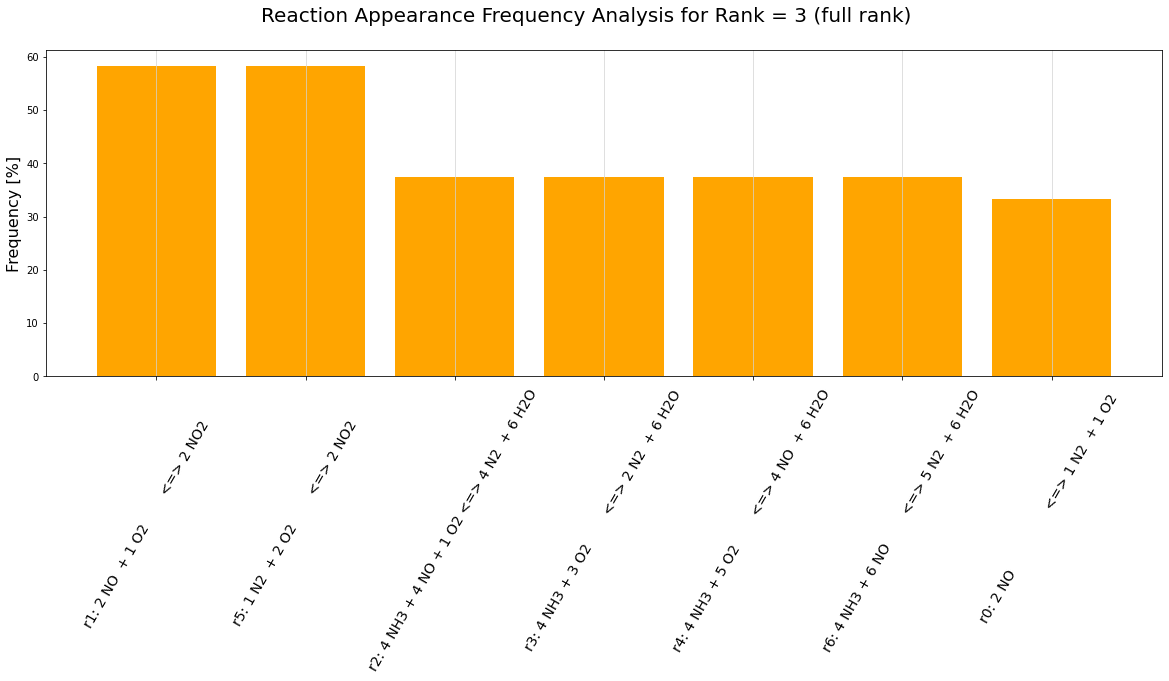

In [11]:
'''Plot the frequency of appearance of reactions in sub-mechanisms'''

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [25, 4]

fig, ax = plt.subplots(figsize=(20,6))

sort_results = sorted(
               zip(reactions, reactions_hits/len(sub_mech_reactions)*100 ), 
                   key = lambda entry: entry[1], reverse=True 
                     )

reactions_sorted = [a for (a,b) in sort_results]
hits_sorted      = [b for (a,b) in sort_results]

ax.bar(reactions_sorted, hits_sorted, color='orange')

for r in reactions_sorted:
    idx = reactions.index(r)
    i = reactions_sorted.index(r)
    reactions_sorted[i] = 'r' + str(idx) + ': ' + r # concatenation of strings and modification of reaction_sorted on the fly
    
plt.xticks( range(len(reactions)), reactions_sorted, rotation=60, fontsize=14 )

ax.set_ylabel('Frequency [%]',fontsize=16)
ax.xaxis.grid( True, linestyle='-', which='major', color='lightgrey',alpha=0.9)
fig.suptitle('Reaction Appearance Frequency Analysis for Rank = '+str(s_rank)+' (full rank)', fontsize=20)
plt.show()

## [Principal reaction sub-mechanisms](#toc)<a id="principal"></a>


In [12]:
'''Scoring the full-rank reaction sub-mechanisms'''

# Temporary space to collect scores
sub_mech_reactions_score = list()

for s in sub_mech_reactions:
    score = 0
    for i in s[0]:
        score += reactions_hits[i]            # score is the sum of the hits for each reaction
    sub_mech_reactions_score.append(score) 

sub_mech_reactions_score = np.array(sub_mech_reactions_score) 
sub_mech_reactions_score /= sub_mech_reactions_score.max()
sub_mech_reactions_score *= 10.0 # max score value

results = sorted( zip( sub_mech_reactions, sub_mech_reactions_score ), 
                  key=lambda entry: entry[1], reverse=True )

# save sorted lists
sub_mech_reactions       = [a for (a,b) in results]
sub_mech_reactions_score = [b for (a,b) in results]

In [17]:
'''Save scores of the full-rank reaction sub-mechanisms'''

# Encode score in to sub_mech_reactions mech. data structure

for (smr, score) in zip(sub_mech_reactions, sub_mech_reactions_score):
    smr += [score] # create a list and concatenate

In [18]:
'''Principal reaction sub-mechanisms'''

max_score = max( [smr[2] for smr in sub_mech_reactions] )

for smr  in sub_mech_reactions:
    if smr[2] < max_score: 
        continue # skip all but maximum
    print('Linearly Independent Reaction Set %s score %s'%\
          ( sub_mech_reactions.index(smr), smr[2]) )
    for (i,r) in zip(smr[0],smr[1]):
        print('r%s'%i,r)

Linearly Independent Reaction Set 0 score 10.0
r1 2 NO  + 1 O2        <=> 2 NO2         
r2 4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O 
r5 1 N2  + 2 O2        <=> 2 NO2         
Linearly Independent Reaction Set 1 score 10.0
r1 2 NO  + 1 O2        <=> 2 NO2         
r3 4 NH3 + 3 O2        <=> 2 N2  + 6 H2O 
r5 1 N2  + 2 O2        <=> 2 NO2         
Linearly Independent Reaction Set 2 score 10.0
r1 2 NO  + 1 O2        <=> 2 NO2         
r4 4 NH3 + 5 O2        <=> 4 NO  + 6 H2O 
r5 1 N2  + 2 O2        <=> 2 NO2         
Linearly Independent Reaction Set 3 score 10.0
r1 2 NO  + 1 O2        <=> 2 NO2         
r5 1 N2  + 2 O2        <=> 2 NO2         
r6 4 NH3 + 6 NO        <=> 5 N2  + 6 H2O 


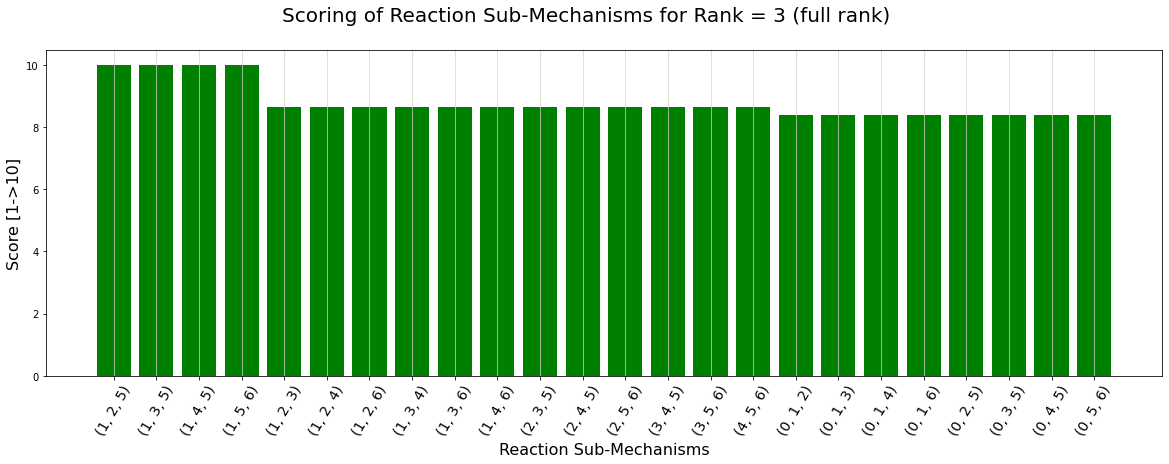

r0 :  2 NO                <=> 1 N2  + 1 O2  
r1 :  2 NO  + 1 O2        <=> 2 NO2         
r2 :  4 NH3 + 4 NO + 1 O2 <=> 4 N2  + 6 H2O 
r3 :  4 NH3 + 3 O2        <=> 2 N2  + 6 H2O 
r4 :  4 NH3 + 5 O2        <=> 4 NO  + 6 H2O 
r5 :  1 N2  + 2 O2        <=> 2 NO2         
r6 :  4 NH3 + 6 NO        <=> 5 N2  + 6 H2O 
n_reactions = 7


In [19]:
'''Principal reaction sub-mechanisms plot'''

fig, ax = plt.subplots(figsize=(20,6))

ax.bar(range(len(sub_mech_reactions)), [smr[2] for smr in sub_mech_reactions],color='green')

plt.xticks(range(len(sub_mech_reactions)), [smr[0] for smr in sub_mech_reactions], rotation=60,fontsize=14)

ax.set_ylabel('Score [1->10]',fontsize=16)
ax.set_xlabel('Reaction Sub-Mechanisms',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)
fig.suptitle('Scoring of Reaction Sub-Mechanisms for Rank = '+str(s_rank)+' (full rank)',fontsize=20)
plt.show()

print_reactions(reactions)